<a href="https://www.kaggle.com/code/mrylahounou/conoravirus-sentiment-analysis?scriptVersionId=125567732" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Ce projet est réalisé dans le but de s'exercer à l'analyse de sentiment en NLP. Dans ce cadre, j'ai travaillé sur la base de données de Kaggle https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification.
Pour ce faire, j'ai classifer les différents tweets selon trois catégories (Positive, Neutre, Négative) en:
- Nettoyant le corpus (suppression des urls, des caractères spéciaux, des stopwords, lemmatization, suppression des mots avec moins de deux caractères...)
- Visualiser le corpus
- Encodant le corpus (Embeding) avec TF-IDF puis j'ai réalisé une première classification avec un Random Forest. J'ai aussi, essayé l'encodage et la classification avec RoBERTa.

J'ai pu avoir un accuracy autour de 80% sur l'échantillon test avec RoBERTa et un accuracy autour de 70% avec le Random Forest.

# Importation des modules

In [1]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.1 MB/s eta 0:00:00


In [2]:
import nltk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re #for regular expressions
import spacy
import tensorflow as tf



from bs4 import BeautifulSoup #to remove web characters
from collections import Counter # count the different occurrences in the list
from gensim.parsing.preprocessing import remove_stopwords # drope stopwords
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from nltk.tokenize import WhitespaceTokenizer # Tokenize a string on whitespace (space, tab, newline)
from nltk.stem import WordNetLemmatizer # Lemmatize using WordNet's built-in morphy function
from pandarallel import pandarallel # parallelization of work
from PIL import Image
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score
from transformers import RobertaTokenizerFast, TFRobertaModel
from tensorflow import keras
from unidecode import unidecode
from wordcloud import WordCloud # generate wordcloud

In [3]:
pandarallel.initialize(progress_bar = True)
load_model = spacy.load("en_core_web_sm")

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Fonctions

In [4]:
def remove_mentions(text):
    """supprime les mentions du corpus"""
    text = re.sub("(\S+)?@\S+", ' ', text)
    text = re.sub(r"^.+@", " ", text)
    return text.strip()

    
def remove_two_char(text):
    """supprime les mots de moins de deux charactères du corpus"""
    for x in text.split():
        if len(x) <= 2:
            text = re.sub("(^" + re.escape(x) + "\s+)" \
                        "|(\s+" + re.escape(x) + "\s+)" \
                        "|(\s+" + re.escape(x) + "$)" \
                        , " ", text)
    return text.strip()


def remove_hashtags(text):
    """supprime les hashtags du corpus"""
    text = re.sub('(#\w+)', ' ', text)
    return text.strip()

punctuation = ":" + '.' + '&' + '?' + ',' + '%' + '$' + '"' + '!' + '*' + ';' + '~' + '+' + '>'

# Main function with preprocessing 
def preprocess(text):
    """Réalise le préproccesing du corpus"""
    text = re.sub(r'[^\x00-\x7f]',r'\'', text) # remplace des caractères unicodes par '
    text = unidecode(text, errors="preserve") # gère les caractères unicode non gérées par l'encodage "latin"
    text= re.sub("\s{2,}", " ", text)
    text = remove_hashtags(text)
    text = remove_mentions(text)
    text = re.sub("[\(\)\\\[\]\|]", " ", text)
    text = str(text)
    text = text.lower()
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub("\S*https?:\S+", " ", text)
    text = re.sub("\d+", " ", text)
    text = re.sub(r"["+punctuation+ "#|\/""]", " ", text)
    text = text.replace("-", " ") 
    text = " ".join([token.lemma_ for token in load_model(text)])
    text = re.sub("^covid\s+|\s+covid\s+|\s+covid$", " coronavirus ", text)
    text = re.sub("^coronaviru\s+|\s+coronaviru\s+|\s+coronaviru$", " coronavirus ", text)
    text = re.sub("^coronaviruss\s+|\s+coronaviruss\s+|\s+coronaviruss\$", " coronavirus ", text)
    text = re.sub("^corona\s+|\s+corona\s+|\s+corona$", " coronavirus ", text)
    text = re.sub("^ummmmmmmmmm\s+|\s+ummmmmmmmmm\s+|\s+ummmmmmmmmm$", " ", text)
    text = re.sub("^iam\s+|\s+iam\s+|\s+iam$", " ", text)
    text = re.sub("^i\'m\s+|\s+i\'m\s+|\s+i\'m$", " ", text)
    text = re.sub("^it\'s\s+|\s+it\'s\s+|\s+it\'s$", " ", text)
    text = re.sub(" \'ve ", " have ", text)
    text = re.sub("aaa|aaaa|aaaaaaaaaa|zzz|zzzz", " ", text) 
    text = re.sub("govt", 'government', text)  
    text = re.sub(" isn\' ", ' is not ', text) 
    text = remove_two_char(text) 
    text = remove_stopwords(text)
    return text.strip()



def recode_sentiment(x):
    if x == "Extremely Negative":
        x = "Negative"
    elif x == "Extremely Positive":
        x = "Positive"
    return x


def text_len(text):
    return len(text.split()) 


def create_model(bert_model, max_len):
    """Création du modèle RoBERTa"""
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-6, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

# Chargement base de données

In [5]:
df_train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv',
                      encoding='latin')
df_test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv',
                     encoding='latin')

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative


In [8]:
df_train.shape

(41157, 6)

In [9]:
df_train = df_train.drop_duplicates(subset=['OriginalTweet'])

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [11]:
df_train.Sentiment = df_train.Sentiment.apply(lambda x: recode_sentiment(x))
df_train.Sentiment.value_counts(normalize=True)

Positive    0.438467
Negative    0.374128
Neutral     0.187404
Name: Sentiment, dtype: float64

In [12]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1",Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg staged event?\r\r\n\r\r\nhttps://t.co/IASiReGPC4\r\r\n\r\r\n#QAnon #QAnon2018 #QAnon2020 \r\r\n#Election2020 #CDC https://t.co/29isZOewxu,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next everyone buying up toilet paper. https://t.co/ScZryVvsIh,Neutral


In [13]:
df_test.shape

(3798, 6)

In [14]:
df_test = df_test.drop_duplicates(subset=['OriginalTweet'])

In [15]:
df_test.shape

(3798, 6)

In [16]:
df_test.Sentiment = df_test.Sentiment.apply(lambda x: recode_sentiment(x))
df_test.Sentiment.value_counts(normalize=True)

Negative    0.429963
Positive    0.407056
Neutral     0.162981
Name: Sentiment, dtype: float64

In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 207.7+ KB


# Preprocessing

In [18]:
%time df_train['cleaned_text'] = df_train['OriginalTweet'].parallel_apply(preprocess)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:408: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


CPU times: user 3.4 s, sys: 633 ms, total: 4.03 s
Wall time: 6min 16s


In [19]:
df_train['text_len'] = df_train['cleaned_text'].parallel_apply(lambda x: text_len(x))

In [20]:
df_train = df_train[df_train['text_len'] > 3]
df_train = df_train.reset_index(drop=True)
df_train[['OriginalTweet', 'cleaned_text', 'text_len']].head(10)

,OriginalTweet,cleaned_text,text_len
0,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,advice talk neighbour family exchange phone number create contact list phone number neighbours schools employer chemist set online shopping account poss adequate supply regular med order,26
1,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",coronavirus australia woolworth elderly disabled dedicated shopping hour amid coronavirus outbreak,11
2,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",food stock panic food need stay calm stay safe,9
3,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",ready supermarket outbreak paranoid food stock litteraly thing panic cause shortage,11
4,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",news region confirm coronavirus case come sullivan county week people flock area store purchase cleaning supply hand sanitizer food toilet paper good report,23
5,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",cashier grocery store share insight prove credibility comment civic class know talk,12
6,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,supermarket today buy toilet paper,5
7,"Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16. We will continue to process online and phone orders as normal! Thank you for your understanding! https://t.co/kw91zJ5O5i",coronavirus retail store classroom atlanta open walk business class week begin monday march continue process online phone order normal thank understanding,21
8,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona",coronavirus prevention stop buy thing cash use online payment method coronavirus spread note prefer online shopping home time fight coronavirus,20
9,"All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a single supermarket. #manila #lockdown #covid2019 #Philippines https://t.co/HxWs9LAnF9",month crowd supermarket restaurant reduce hour close mall mean use entrance dependent single supermarket,14


In [21]:
%time df_test['cleaned_text'] = df_test['OriginalTweet'].parallel_apply(preprocess)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


CPU times: user 380 ms, sys: 139 ms, total: 519 ms
Wall time: 38.5 s


In [22]:
df_test['text_len'] = df_test['cleaned_text'].parallel_apply(lambda x: text_len(x))

In [23]:
df_test = df_test[df_test['text_len'] > 3]
df_test = df_test.reset_index(drop=True)
df_test[['OriginalTweet', 'cleaned_text', 'text_len']].head(10)

,OriginalTweet,cleaned_text,text_len
0,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1",trend new yorker encounter supermarket shelf picture wegman brooklyn sell online grocer foodkick maxdelivery fear shopper stock,17
1,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",hand sanitizer fred meyer turn pack purell check concern drive price,11
2,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg staged event?\r\r\n\r\r\nhttps://t.co/IASiReGPC4\r\r\n\r\r\n#QAnon #QAnon2018 #QAnon2020 \r\r\n#Election2020 #CDC https://t.co/29isZOewxu,buy hit city anxious shopper stock food medical supply worker confirm patient stage event,14
3,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next everyone buying up toilet paper. https://t.co/ScZryVvsIh,week buy baby milk powder buy toilet paper,8
4,Do you remember the last time you paid $2.99 a gallon for regular gas in Los Angeles?Prices at the pump are going down. A look at how the #coronavirus is impacting prices. 4pm @ABC7 https://t.co/Pyzq8YMuV5,remember time pay gallon regular gas los angeles price pump look impact price,13
5,Voting in the age of #coronavirus = hand sanitizer ? #SuperTuesday https://t.co/z0BeL4O6Dk,vote age hand sanitizer,4
6,"@DrTedros ""We canÂt stop #COVID19 without protecting #healthworkers.\r\r\nPrices of surgical masks have increased six-fold, N95 respirators have more than trebled &amp; gowns cost twice as much""-@DrTedros #coronavirus",stop protect price surgical mask increase fold respirator treble gown cost twice,12
7,"HI TWITTER! I am a pharmacist. I sell hand sanitizer for a living! Or I do when any exists. Like masks, it is sold the fuck out everywhere. SHOULD YOU BE WORRIED? No. Use soap. SHOULD YOU VISIT TWENTY PHARMACIES LOOKING FOR THE LAST BOTTLE? No. Pharmacies are full of sick people.",twitter pharmacist sell hand sanitizer living exist like mask sell fuck worry use soap visit pharmacy look bottle pharmacy sick people,21
8,"Anyone been in a supermarket over the last few days? Went to do my NORMAL shop last night &amp; ??is the sight that greeted me. Barmy! (Btw, whatÂs so special about tinned tomatoes? ????????????). #Covid_19 #Dublin https://t.co/rGsM8xUxr6",supermarket day normal shop night sight greet barmy btw special tin tomato,12
9,Best quality couches at unbelievably low prices available to order.\r\r\n\r\r\nWe are in Boksburg GP \r\r\n\r\r\nFor more info WhatsApp:\r\r\n084 764 8086\r\r\n\r\r\n#SuperTuesdsy #PowerTalk \r\r\n#Covid_19 #SayEntrepreneur \r\r\n#DJSBU https://t.co/HhDJhyQ2Dc,good quality couch unbelievably low price available order boksburg info whatsapp,11


## Dictionnaire de mots

In [24]:
text = df_train['cleaned_text'].tolist() + df_test['cleaned_text'].tolist()

In [25]:
len(text)

43014

In [26]:
tk = WhitespaceTokenizer()
all_tokens = []
for doc in text:
    all_tokens += tk.tokenize(doc)
print("Number tokens:", len(all_tokens))
Counter(all_tokens).most_common(500)

Number tokens: 596741


[('coronavirus', 13966),
 ('price', 9342),
 ('store', 9320),
 ('food', 8366),
 ('supermarket', 7685),
 ('grocery', 7275),
 ('people', 6387),
 ('consumer', 5217),
 ('need', 3954),
 ('online', 3826),
 ('time', 3410),
 ('stock', 3358),
 ('work', 3271),
 ('panic', 3165),
 ('worker', 2992),
 ('shopping', 2929),
 ('hand', 2879),
 ('pandemic', 2828),
 ('help', 2750),
 ('like', 2701),
 ('buy', 2679),
 ('home', 2656),
 ('demand', 2543),
 ('shop', 2543),
 ('sanitizer', 2489),
 ('supply', 2250),
 ('day', 2145),
 ('good', 2113),
 ('week', 1919),
 ('stay', 1880),
 ('toilet', 1842),
 ('use', 1828),
 ('new', 1825),
 ('paper', 1819),
 ('mask', 1818),
 ('crisis', 1731),
 ('local', 1675),
 ('shelf', 1670),
 ('business', 1666),
 ('today', 1628),
 ('oil', 1608),
 ('think', 1566),
 ('know', 1562),
 ('delivery', 1558),
 ('market', 1550),
 ('thank', 1479),
 ('essential', 1443),
 ('increase', 1426),
 ('amp', 1425),
 ('stop', 1401),
 ('come', 1400),
 ('look', 1379),
 ('spread', 1363),
 ('buying', 1346),
 ('gov

In [27]:
frequencies = Counter(all_tokens)

In [28]:
text_pos = df_train[df_train["Sentiment"] == "Positive"]['cleaned_text'].tolist() \
            + df_test[df_test["Sentiment"] == "Positive"]['cleaned_text'].tolist()
all_tokens_pos = []
for doc in text_pos:
    all_tokens_pos += tk.tokenize(doc)
print("Number tokens:", len(all_tokens_pos))
frequencies_pos = Counter(all_tokens_pos)

Number tokens: 278021


In [29]:
text_neg = df_train[df_train["Sentiment"] == "Negative"]['cleaned_text'].tolist() \
            + df_test[df_test["Sentiment"] == "Negative"]['cleaned_text'].tolist()
all_tokens_neg = []
for doc in text_neg:
    all_tokens_neg += tk.tokenize(doc)
print("Number tokens:", len(all_tokens_neg))
frequencies_neg = Counter(all_tokens_neg)

Number tokens: 242573


In [30]:
text_neu = df_train[df_train["Sentiment"] == "Neutral"]['cleaned_text'].tolist() \
            + df_test[df_test["Sentiment"] == "Neutral"]['cleaned_text'].tolist()
all_tokens_neu = []
for doc in text_neu:
    all_tokens_neu += tk.tokenize(doc)
print("Number tokens:", len(all_tokens_neu))
frequencies_neu = Counter(all_tokens_neu)

Number tokens: 76147


## Wordcloud

In [31]:
mask = np.array(Image.open("/kaggle/input/image-wordcloud/cloud.png"))

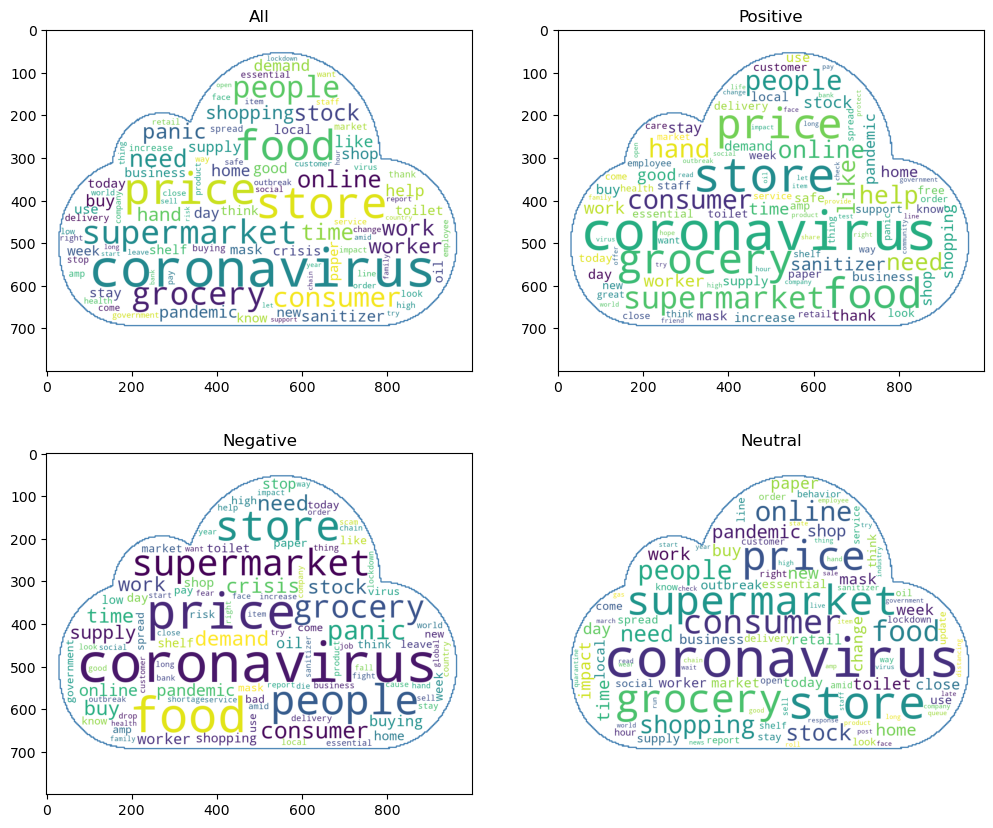

In [32]:
plt.figure(figsize=(25,30))

wordcloud = WordCloud(background_color="white", max_words=100, contour_color='steelblue', \
                      contour_width=3, mask = mask).generate_from_frequencies(frequencies)
wordcloud_pos = WordCloud(background_color="white", max_words=100, contour_color='steelblue', \
                      contour_width=3, mask = mask).generate_from_frequencies(frequencies_pos)
wordcloud_neg = WordCloud(background_color="white", max_words=100, contour_color='steelblue', \
                      contour_width=3, mask = mask).generate_from_frequencies(frequencies_neg)
wordcloud_neu = WordCloud(background_color="white", max_words=100, contour_color='steelblue', \
                      contour_width=3, mask = mask).generate_from_frequencies(frequencies_neu)

plt.subplots_adjust(bottom=0.1, right=0.5, top=0.5)
plt.subplot(3,2,1)
plt.imshow(wordcloud)
plt.title("All")

plt.subplots_adjust(bottom=0.1, right=0.5, top=0.5)
plt.subplot(3,2,2)
plt.imshow(wordcloud_pos)
plt.title("Positive")

plt.subplots_adjust(bottom=0.1, right=0.5, top=0.5)
plt.subplot(3,2,3)
plt.imshow(wordcloud_neg)
plt.title("Negative")

plt.subplots_adjust(bottom=0.1, right=0.5, top=0.5)
plt.subplot(3,2,4)
plt.imshow(wordcloud_neu)
plt.title("Neutral")

plt.axis("off")
plt.show()

# Vectorisation

## TF-IDF

TF-IDF est un algorithme d'apprentissage automatique (ML) basé sur une mesure statistique de la pertinence des mots dans le texte. Le texte peut se présenter sous la forme d'un document ou de plusieurs documents (corpus). Il s'agit d'une combinaison de deux mesures : La fréquence des termes (TF) et la fréquence inverse des documents (IDF).

Le score TF est basé sur la fréquence des mots dans un document. Les mots sont comptés en fonction de leur nombre d'occurrences dans les documents. La TF est calculée en divisant le nombre d'occurrences d'un mot (i) par le nombre total (N) de mots dans le document (j).

 

TF (i) = log (fréquence (i,j)) / log (N (j))

 

Le score IDF calcule la rareté des mots. Il est important car TF donne plus de poids aux mots qui apparaissent plus fréquemment. Cependant, les mots rarement utilisés dans le corpus peuvent contenir des informations significatives. L'IDF capture cette information. Il peut être calculé en divisant le nombre total (N) de documents (d) par le nombre de documents contenant le mot (i).

 

IDF (i) = log (N (d) / fréquence (d,i))

 

Le logarithme est utilisé dans les formules ci-dessus pour atténuer l'effet des scores élevés pour TF et IDF. Le score TF-IDF final est calculé en multipliant les scores TF et IDF.

L'algorithme TF-IDF est utilisé pour résoudre des problèmes ML et NLP plus simples. Il est mieux adapté à la recherche d'informations, à l'extraction de mots-clés, à la suppression des mots vides (comme "a", "the", "are", "is") et à l'analyse de texte de base. Il ne peut pas capturer efficacement la signification sémantique des mots dans une séquence.

Source: https://www.kdnuggets.com/2021/11/guide-word-embedding-techniques-nlp.html

In [33]:
vectorizer = TfidfVectorizer()

In [34]:
X = vectorizer.fit_transform(text)

In [35]:
vectorizer.get_feature_names_out()

array(['aabutan', 'aahh', 'aajeevika', ..., 'zwd', 'zweli', 'zwoferink'],
      dtype=object)

In [36]:
X.shape

(43014, 26312)

# RoBERTa

RoBERTa pour Robustly optimized BERT approach est un transformers dérivé de BERT(Bidirectional Encoder Representations from Transformers). Un BERT optimisé on peut dire. En effet, BERT peut donner de meilleurs performances lorsqu’on réalise :
-	un entraînement du modèle plus long, avec des lots plus importants, sur davantage de données
-	une suppression de l'objectif de prédiction de la phrase suivante 
-	un entraînement sur des séquences plus longues 
-	une modification dynamique du modèle de masquage appliqué aux données d'entraînement.

In [37]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [38]:
X_train_rb = df_train['cleaned_text']
X_test_rb = df_test['cleaned_text']

In [39]:
ohe = preprocessing.OneHotEncoder()

y_train_rb = df_train['Sentiment']
y_test_rb = df_test['Sentiment']

y_train_rb = ohe.fit_transform(np.array(y_train_rb).reshape(-1, 1)).toarray()
y_test_rb = ohe.fit_transform(np.array(y_test_rb).reshape(-1, 1)).toarray()

In [40]:
print(X_train_rb.shape, X_test_rb.shape, y_train_rb.shape, y_test_rb.shape)

(39332,) (3682,) (39332, 3) (3682, 3)


In [41]:
token_lens = []

for txt in X_train_rb:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length = np.max(token_lens)
max_length

85

In [42]:
MAX_LEN = 128

In [43]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [44]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train_rb, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test_rb, MAX_LEN)

In [45]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [46]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [47]:
callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True, verbose=1, mode="max"),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
]

In [48]:
%time history_2 = model.fit([train_input_ids,train_attention_masks], y_train_rb, \
                      validation_data=([test_input_ids, test_attention_masks], y_test_rb), epochs=20, batch_size=32, callbacks=callbacks)

Epoch 1/20
1230/1230 [==============================] - 622s 492ms/step - loss: 0.8143 - categorical_accuracy: 0.6330 - val_loss: 0.7060 - val_categorical_accuracy: 0.7072 - lr: 1.0000e-06
Epoch 2/20
1230/1230 [==============================] - 602s 490ms/step - loss: 0.6492 - categorical_accuracy: 0.7355 - val_loss: 0.6393 - val_categorical_accuracy: 0.7444 - lr: 1.0000e-06
Epoch 3/20
1230/1230 [==============================] - 603s 490ms/step - loss: 0.5944 - categorical_accuracy: 0.7644 - val_loss: 0.6156 - val_categorical_accuracy: 0.7596 - lr: 1.0000e-06
Epoch 4/20
1230/1230 [==============================] - 603s 490ms/step - loss: 0.5597 - categorical_accuracy: 0.7813 - val_loss: 0.5850 - val_categorical_accuracy: 0.7749 - lr: 1.0000e-06
Epoch 5/20
1230/1230 [==============================] - 604s 491ms/step - loss: 0.5361 - categorical_accuracy: 0.7948 - val_loss: 0.5674 - val_categorical_accuracy: 0.7846 - lr: 1.0000e-06
Epoch 6/20
1230/1230 [==============================] -

In [49]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

116/116 [==============================] - 22s 164ms/step


In [50]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [51]:
accuracy = round(accuracy_score(y_test_rb, y_pred_roberta), 3)
precision = round(precision_score(y_test_rb, y_pred_roberta, average='macro'), 3)
recall = round(recall_score(y_test_rb, y_pred_roberta, average='macro'), 3)
print('A: {} / P: {} / R: {}'.format(accuracy,
                                     precision,
                                     recall))

A: 0.814 / P: 0.795 / R: 0.789


# Random Forest

## Entrainement modèle

## Train / Test

In [52]:
df_train.shape, df_test.shape

((39332, 8), (3682, 8))

In [53]:
X_train = X[:39332]
X_train.shape

(39332, 26312)

In [54]:
X_test = X[39332:]
X_test.shape

(3682, 26312)

In [55]:
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(df_train['Sentiment'])
y_train.shape

(39332,)

In [56]:
y_test = le.fit_transform(df_test['Sentiment'])
y_test.shape

(3682,)

In [57]:
rf = RandomForestClassifier()
%time scores = cross_val_score(rf,X_train,y_train,cv=5)

CPU times: user 7min 19s, sys: 0 ns, total: 7min 19s
Wall time: 7min 20s


In [58]:
print(scores)
scores.mean()

[0.73738401 0.72746918 0.72794305 0.72260361 0.74472413]


0.7320247939693825

### GridSearch

In [59]:
rf = RandomForestClassifier()
parameters = {
     'n_estimators': [5,50,100,200],
#      'max_depth': [2,10,20,50, None],
#      'bootstrap': [True, False],
#      'max_features': ['auto', 'sqrt'],
#      'min_samples_leaf': [1, 2, 4],
#      'min_samples_split': [2, 5, 10]
    }

cv = GridSearchCV(rf,parameters)
%time cv.fit(X_train,y_train)

CPU times: user 29min 59s, sys: 0 ns, total: 29min 59s
Wall time: 30min 1s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [5, 50, 100, 200]})

In [60]:
cv.best_estimator_

RandomForestClassifier(n_estimators=200)

### Feature importances

In [61]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

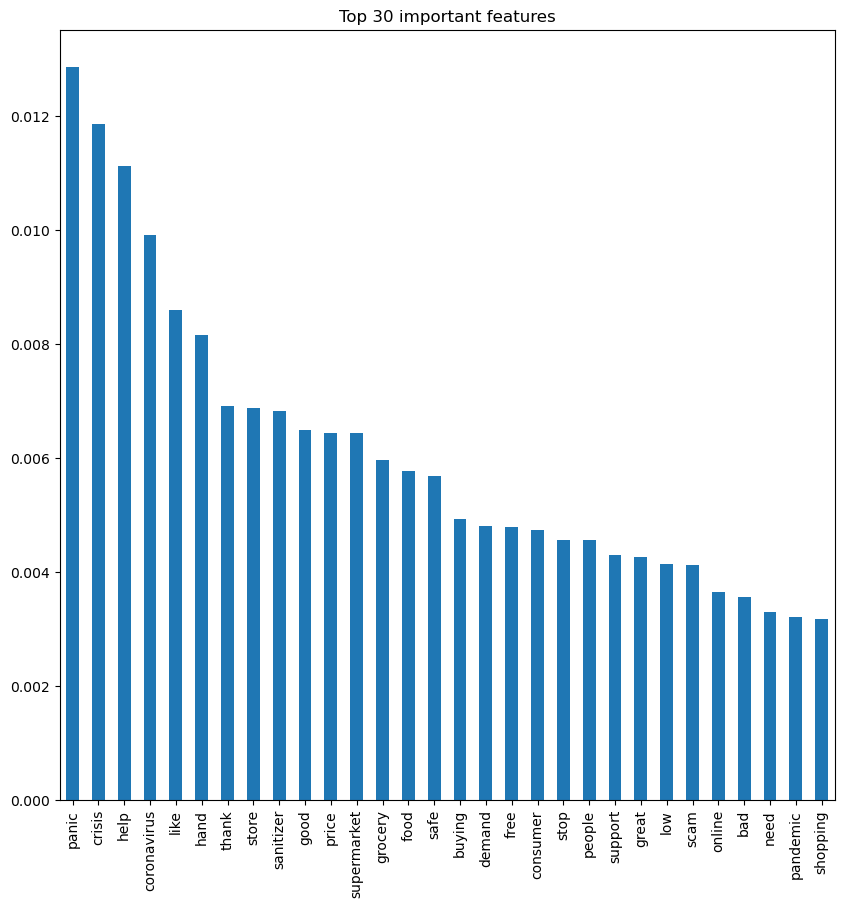

In [62]:
feat_importances = pd.Series(rf.feature_importances_, index=vectorizer.get_feature_names_out())
feat_importances.nlargest(30).plot(kind='bar',figsize=(10,10))
plt.title("Top 30 important features")
plt.show()

## Evaluation modèle

In [63]:
y_pred = rf.predict(X_test)

In [64]:
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, average='macro'), 3)
recall = round(recall_score(y_test, y_pred, average='macro'), 3)
print('A: {} / P: {} / R: {}'.format(accuracy,
                                     precision,
                                     recall))

A: 0.724 / P: 0.697 / R: 0.682
